### DESEQ2 analysis of Hydrogel dataset

2 Factor design: 

* Stiffness (Soft v Stiff) 
* Saha (yes, no) 

* 221511 naive overlap peaks 
* 3 biological replicates per Sample 

In [6]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

## Load data and design

In [7]:
#load ATAC-seq raw read counts
data=read.table('hydrogel.soft.stiff.saha.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL

#data=data[rowSums(data)>0,]


In [8]:
head(data)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3,saha_2000Pa_Rep1,saha_2000Pa_Rep2,saha_2000Pa_Rep3
chr1_713708_714452,6,11,7,17,27,17,25,23,16,22,24,20
chr1_762643_763047,1,5,0,3,7,4,5,5,2,3,6,7
chr1_802987_803295,2,7,4,3,3,1,8,6,6,7,8,4
chr1_804984_805589,2,6,1,6,7,6,7,3,4,5,16,4
chr1_834765_835239,7,12,14,15,7,9,5,2,0,8,10,4
chr1_839144_839717,13,17,5,23,15,20,6,4,3,5,12,11


In [9]:
#load the metadata
batches=read.table("batches_hydrogel.soft.stiff.saha.txt",header=TRUE,sep='\t',row.names=1)
batches$Stiffness=factor(batches$Stiffness)
batches$Saha=factor(batches$Saha)
batches$Sample=factor(batches$Sample)


In [10]:
batches

,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa
saha_100Pa_Rep1,Soft,Yes,saha_100Pa
saha_100Pa_Rep2,Soft,Yes,saha_100Pa
saha_100Pa_Rep3,Soft,Yes,saha_100Pa
saha_2000Pa_Rep1,Stiff,Yes,saha_2000Pa


## Soft vs Stiff Analysis 


In [11]:
soft_stiff_data=data[,1:6]
soft_stiff_batches=batches[1:6,]

In [12]:
head(soft_stiff_data)
soft_stiff_batches

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr1_713708_714452,6,11,7,17,27,17
chr1_762643_763047,1,5,0,3,7,4
chr1_802987_803295,2,7,4,3,3,1
chr1_804984_805589,2,6,1,6,7,6
chr1_834765_835239,7,12,14,15,7,9
chr1_839144_839717,13,17,5,23,15,20


,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa


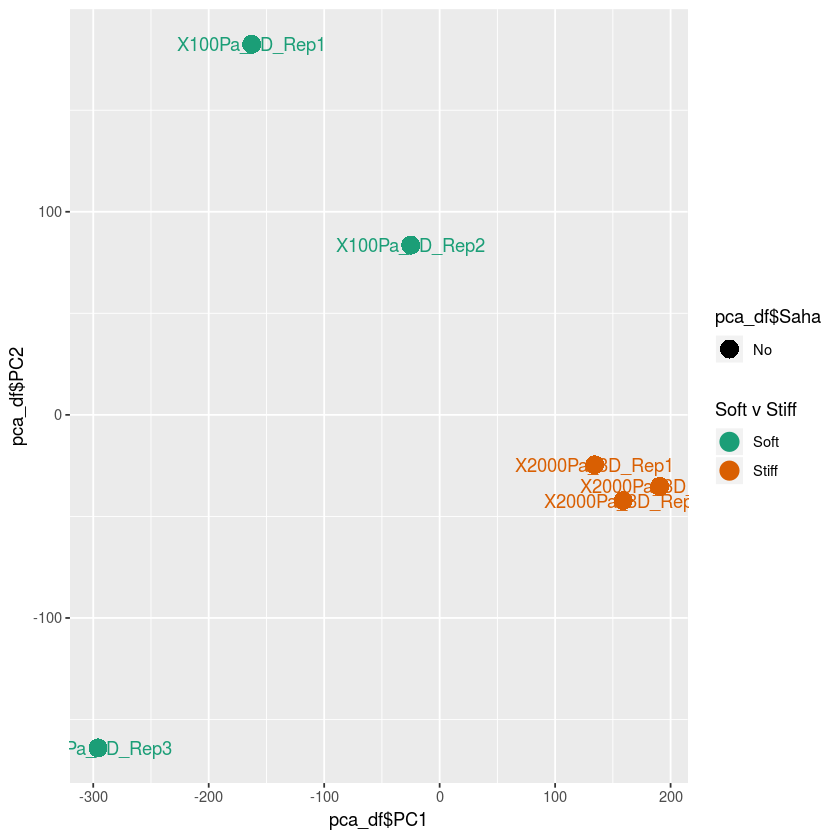

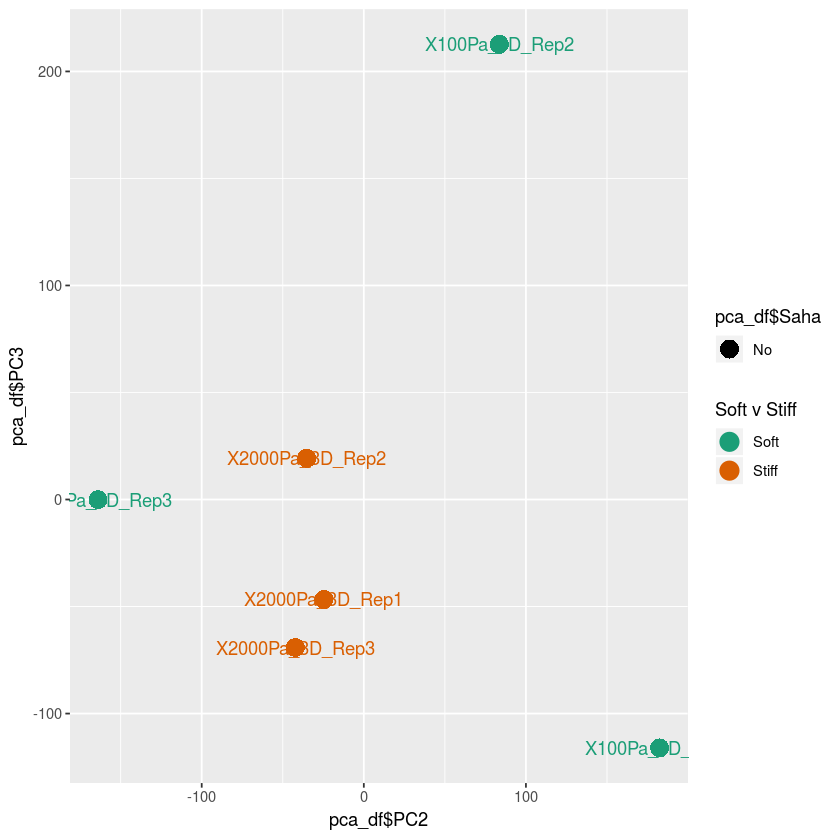

In [13]:
#PCA on shifted log of normalized counts
normcounts=soft_stiff_data
normcounts[normcounts<0]=0
lognc=log2(normcounts+1)
data.pca=prcomp(t(lognc))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)

pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

In [14]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = soft_stiff_data,
                              colData = soft_stiff_batches,
                              design = ~Stiffness)


## Extract and store normalized counts for further analysis 

In [300]:
head(normcounts)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr1_713708_714452,10.389286,8.994839,10.072496,14.223168,18.900482,13.768883
chr1_762643_763047,2.166286,1.837060,2.091492,2.829489,4.345750,3.546150
chr1_802987_803295,5.151955,5.205100,5.164028,2.702348,1.678516,1.028523
chr1_804984_805589,3.249119,3.428959,3.289975,5.216856,4.504169,5.056520
chr1_834765_835239,13.724373,14.860052,13.982376,12.058272,5.473034,6.876461
chr1_839144_839717,13.166284,15.031777,13.590085,18.932519,10.868778,15.927412


## Differential Accessibility Operation

In [ ]:
#Run the differential analysis
dds <- DESeq(dds,parallel = TRUE)
normcounts=counts(dds,normalized=TRUE)
write.table(normcounts,"soft_stiff_normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


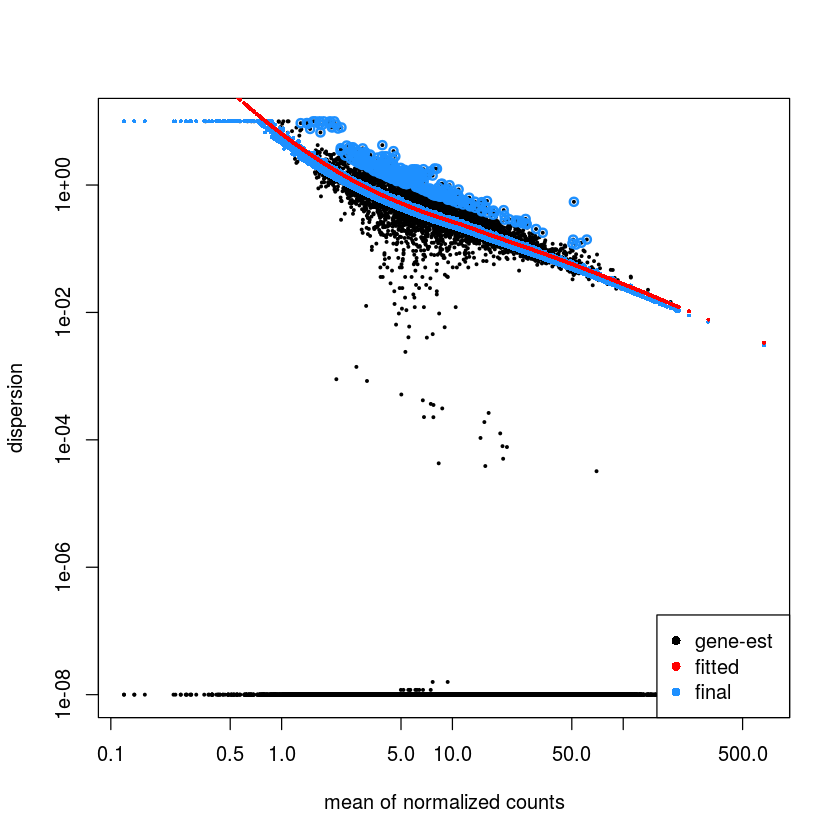

In [302]:
plotDispEsts(dds)

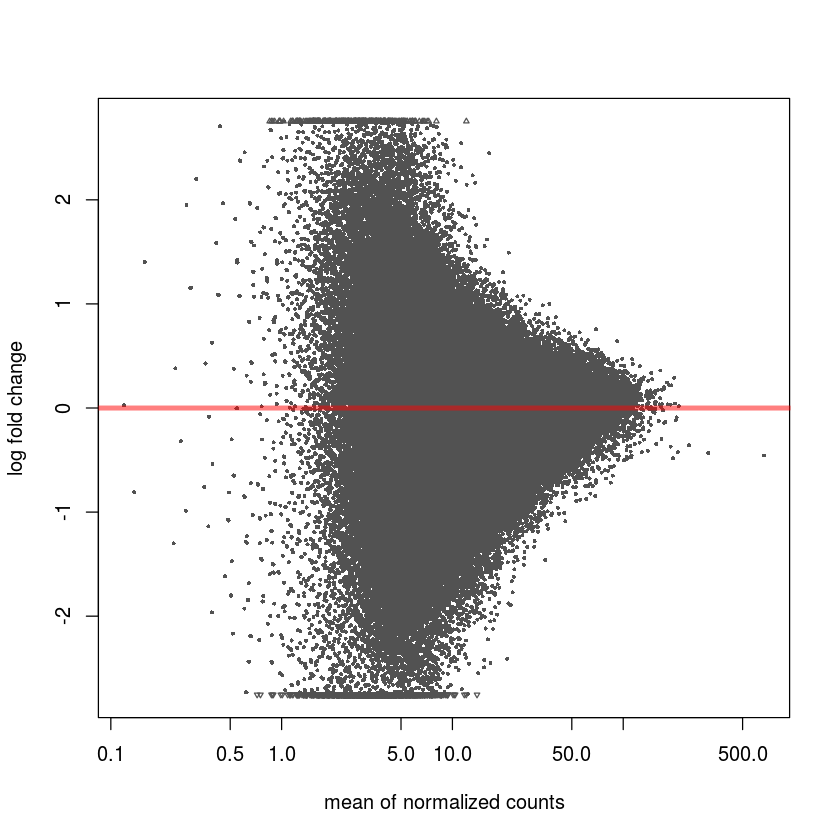

In [303]:
DESeq2::plotMA(dds)

## Standard BH Correction (no optimal thresholding) 

In [304]:
res=results(dds)
summary(res)

res=results(dds,independentFiltering=FALSE)
summary(res)

res=results(dds,filterFun = ihw)
summary(res)


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [305]:

resultsNames(dds)

[1] "Intercept"               "Stiffness_Stiff_vs_Soft"
[3] "sv1"                     "sv2"

In [306]:
res=results(dds,name="Stiffness_Stiff_vs_Soft",parallel=TRUE)

[1] 12


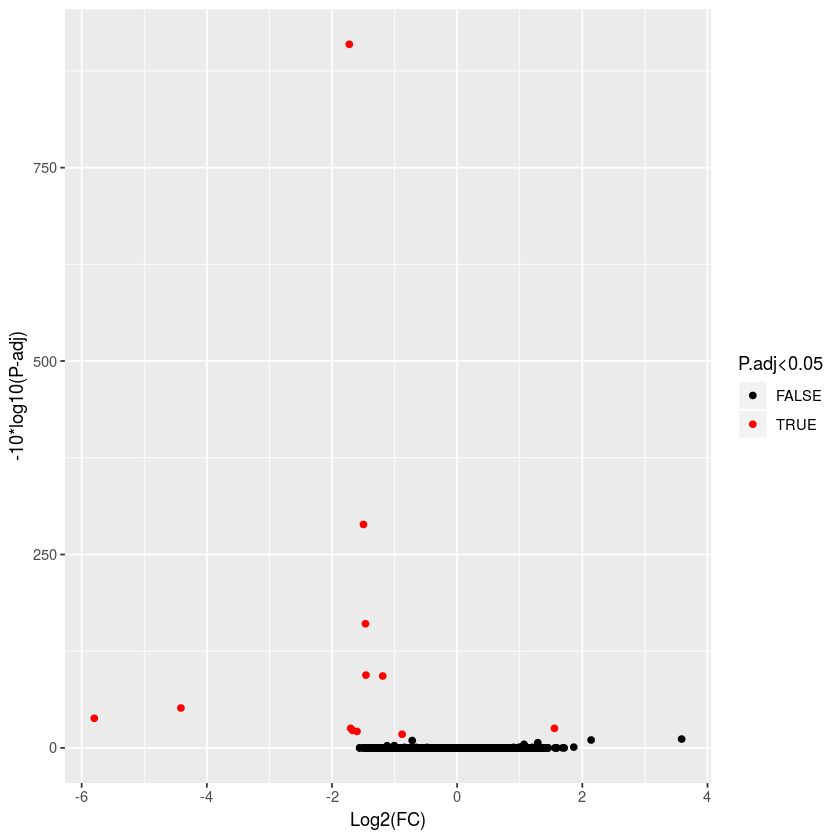

In [307]:
        res$logPadj=-10*log10(res$padj)
        res=as.data.frame(res)
        res=na.omit(res)
        numsig=sum(res$padj <= 0.05)
        sigsubset=res[res$padj<=0.05,]
        res$color=res$padj<=0.05
        ggplot(data=res,
        aes(x=res$log2FoldChange,
                 y=res$logPadj,
                 color=res$color))+
                 geom_point()+
                 xlab("Log2(FC)")+
                 ylab("-10*log10(P-adj)")+
                 scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05")
print(numsig)

## Visualizations 

In [254]:
#PCA on shifted log of normalized counts
normcounts[normcounts<0]=0 
lognorm=log2(normcounts+1)
data.pca=prcomp(t(lognorm))
#rld=assay(rlog(dds,blind=FALSE))
#data.pca=prcomp(t(rld))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [255]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,50.16
2,26.12
3,23.53
4,0.18
5,0.00
6,0.00


In [256]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


png 
  2

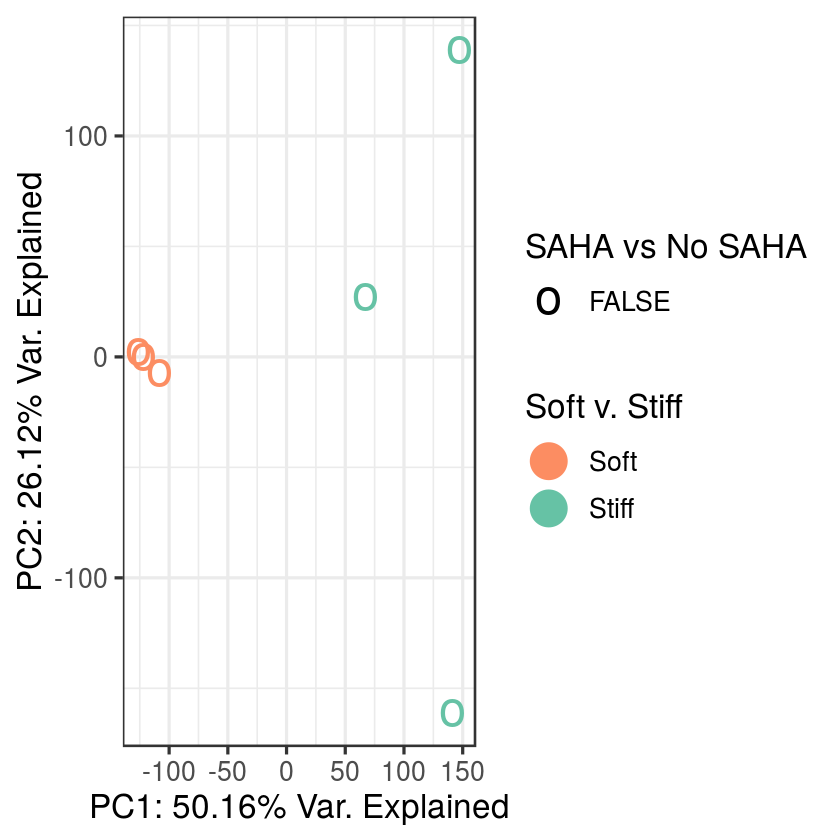

In [257]:
pca_df$Saha=c(FALSE,FALSE,FALSE,FALSE,FALSE,FALSE)
pca_df$Stiffness=c("Soft","Soft","Soft","Stiff","Stiff","Stiff")
pca_df$Saha=factor(pca_df$Saha)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Stiffness,shape=pca_df$Saha))+
  geom_point(size=10) +
  xlab("PC1: 50.16% Var. Explained")+
  ylab("PC2: 26.12% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c("#fc8d62","#66c2a5"),name="Soft v. Stiff")+
  scale_shape_manual(values=c("o","x"),name="SAHA vs No SAHA")
p1
svg("pca.no.saha.svg",width = 8, height = 4, pointsize = 12)
print(p1)
dev.off()

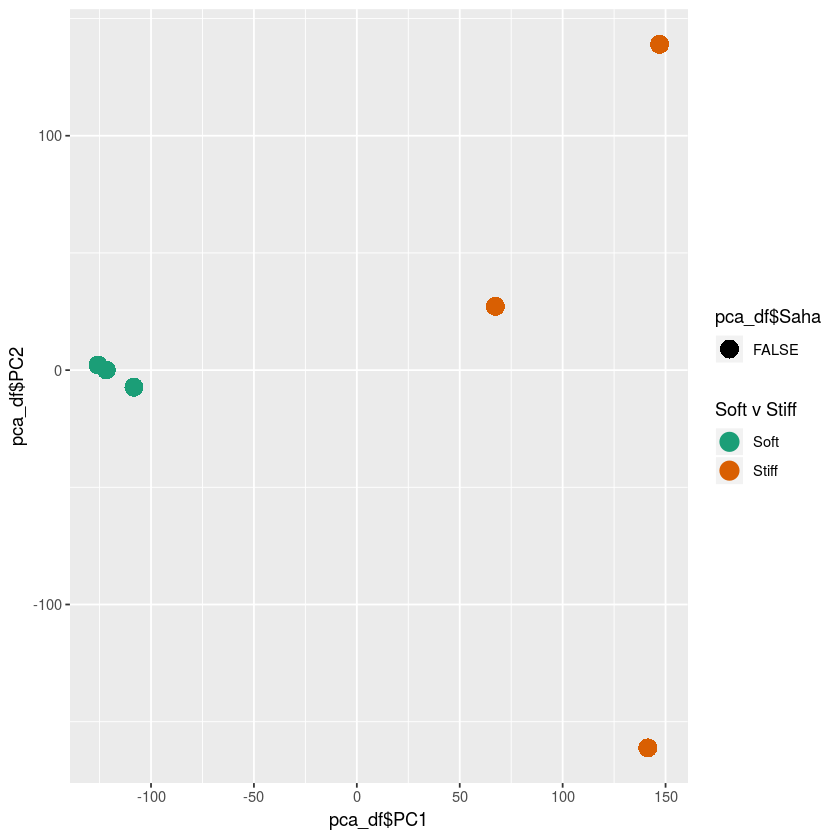

In [258]:
p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

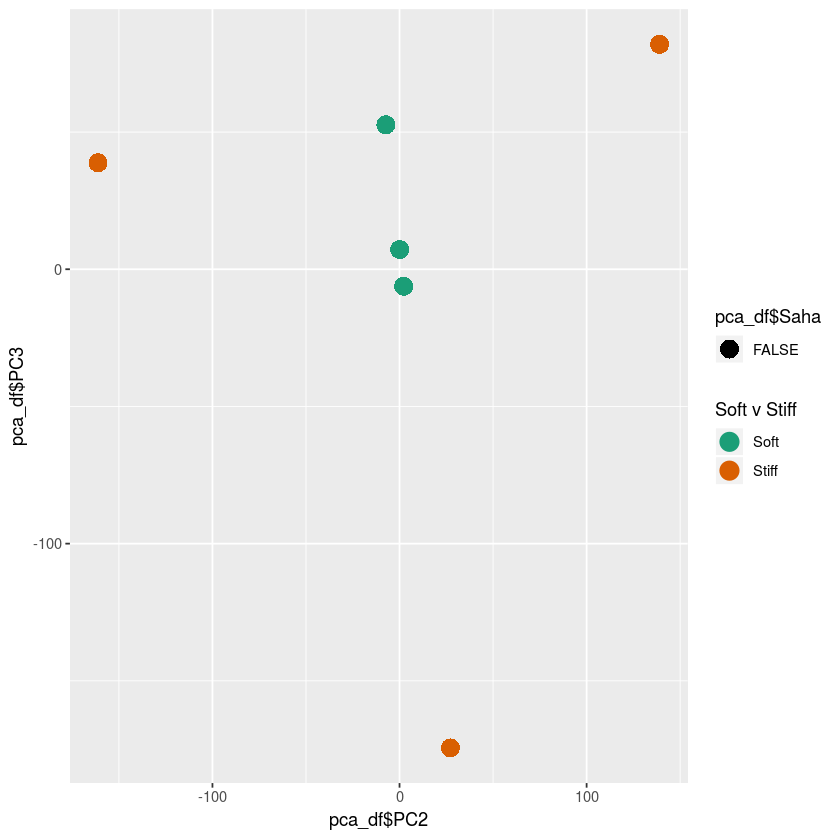

In [259]:
p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

## Get contributions to PC1 

In [260]:
pc1_loadings=sort(data.pca$rotation[, 1])

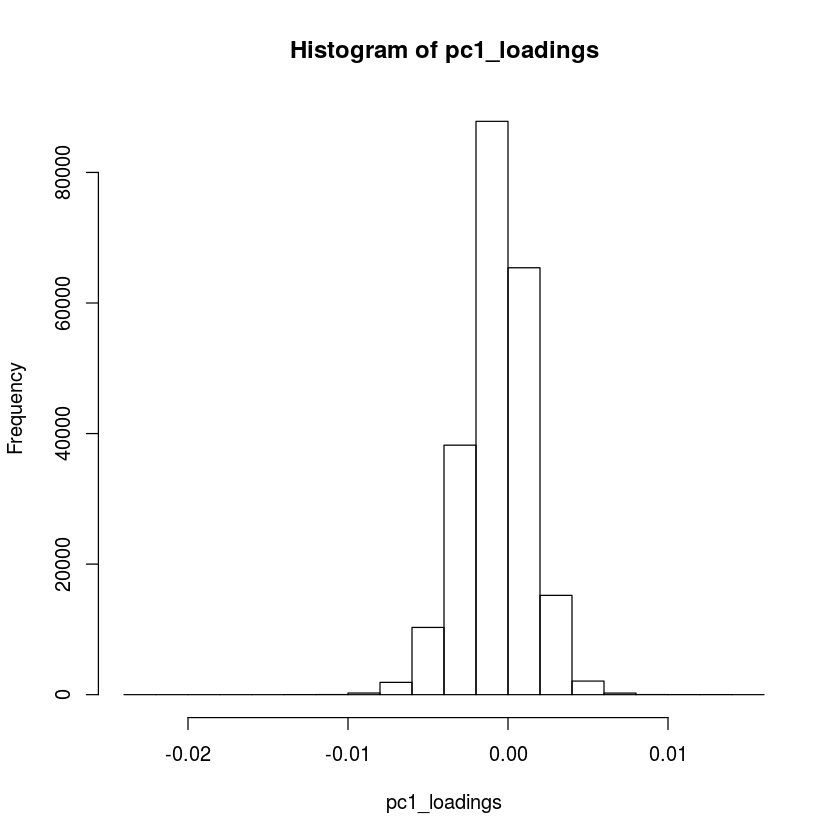

In [261]:
hist(pc1_loadings)

In [262]:
#lower_bound=mean(pc1_loadings)-3*sd(pc1_loadings)
upper_bound=mean(pc1_loadings)+2*sd(pc1_loadings)

In [263]:
#toselect=c(names(pc1_loadings[pc1_loadings<lower_bound]),names(pc1_loadings[pc1_loadings>upper_bound]))
toselect=c(names(pc1_loadings[pc1_loadings>upper_bound]))

In [264]:
#heatmap_indices=match(toselect,rownames(rld))
heatmap_indices=match(toselect,rownames(lognorm))
head(heatmap_indices)
forheatmap=lognorm[heatmap_indices,]

[1]  77977  80285 152512 134036  35362  41567

In [265]:
head(forheatmap)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr16_65543155_65543367,1.494317,1.971094,1.617282,2.507292,1.545958,2.984711
chr16_88689734_88690171,2.909647,2.798330,2.885102,3.599002,3.876730,3.737350
chr4_149436376_149437040,1.479100,1.388384,1.458986,2.633431,2.466530,1.869546
chr3_52567762_52568187,3.239073,3.078422,3.204115,4.174652,4.269472,3.756357
chr11_4647505_4647726,1.413718,1.330990,1.395336,1.816550,2.378443,2.544163
chr11_86185264_86185461,1.413718,1.330990,1.395336,1.816550,2.378443,2.544163


In [266]:
tail(forheatmap)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr7_807695_807926,1.1344181,0.0000000,0.9095055,3.582867,3.956036,3.208627
chr7_8192132_8192432,0.5053428,0.2136589,0.4440642,3.223222,3.338989,3.181337
chr2_133028294_133028519,1.1511002,2.1440720,1.4438483,5.005101,4.370391,4.627797
chr16_33293890_33294396,0.0000000,0.9205402,0.0000000,3.313035,2.941471,4.001733
chr10_111986404_111986644,0.0000000,0.3157455,0.0000000,2.917505,3.375674,4.009591
chr2_1532073_1532506,0.0000000,0.5221078,0.0000000,4.188695,3.652971,3.596546


In [267]:
nrow(forheatmap)

[1] 4542

In [268]:
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(100)

In [269]:
df <- as.data.frame(colData(dds)[,'Stiffness'])


png 
  2

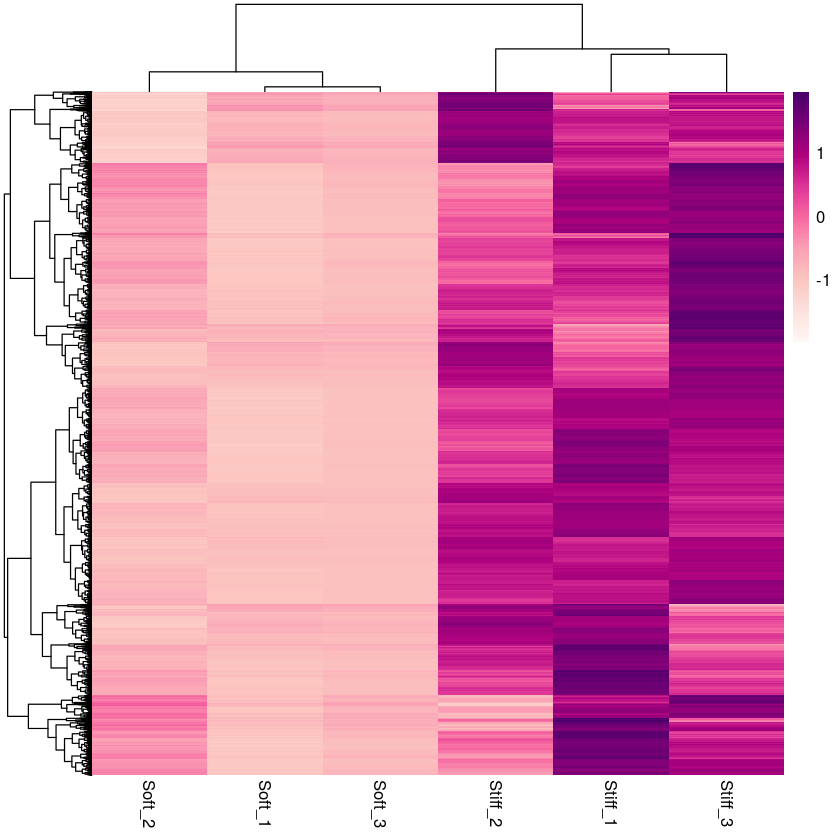

In [270]:
p1=pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3"))
svg("soft.stiff.zscores.svg")
print(p1)
dev.off() 


In [271]:
head(rownames(forheatmap))

[1] "chr16_65543155_65543367"  "chr16_88689734_88690171" 
[3] "chr4_149436376_149437040" "chr3_52567762_52568187"  
[5] "chr11_4647505_4647726"    "chr11_86185264_86185461"

In [273]:
write.table(forheatmap,file="pc1.soft.stiff.highest.tsv",row.names=TRUE,col.names=TRUE,sep='\t')

## SP1 Peaks

In [197]:
strongest_sp1=read.table("../../homer//explicit_sp1_scan/sp1.txt",header=TRUE,sep='\t')


In [198]:
head(strongest_sp1)

PositionID,Offset,Sequence,Motif.Name,Strand,MotifScore
221467,-59,GGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,14.545522
221467,-39,AGGCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,10.792980
221467,14,AGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,13.450600
221467,46,AGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,13.450600
221467,96,CTGGGCGGAGCG,Sp1(Zf)/Promoter/Homer,-,9.031086
221467,-55,CTGGGCGGGCCC,Sp1(Zf)/Promoter/Homer,-,8.968299


In [199]:
for_heatmap=lognorm[strongest_sp1$PositionID,]

In [200]:
head(for_heatmap)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874
chrX_155110352_155111621,5.018915,5.082139,5.033523,5.060003,4.640416,4.740874


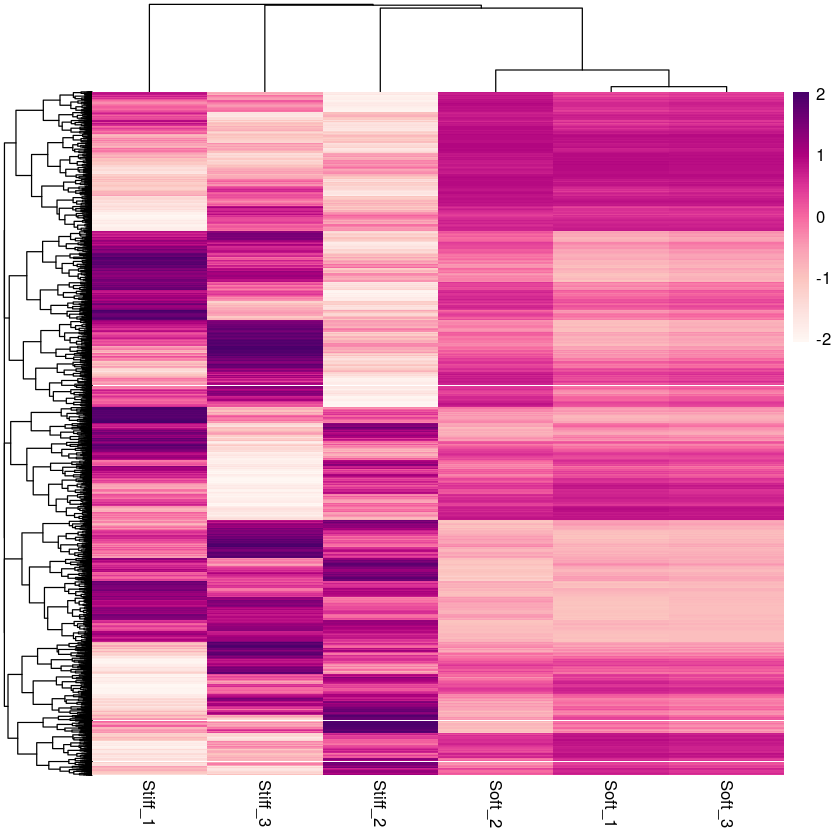

In [201]:
p1=pheatmap(for_heatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3"))

In [202]:
write.table(for_heatmap,file="peaks_with_sp1.bed",row.names=TRUE,col.names=TRUE,sep='\t',quote=FALSE)